In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_files  
from sklearn.model_selection import train_test_split

from keras.preprocessing import image     
from tqdm import tqdm
from PIL import Image
from random import shuffle


import keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.applications.densenet import DenseNet121
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator


import numpy as np




Using TensorFlow backend.


# Problems
- Accuracy is good but no better than guess all one class. Think this could be solved by addressing class imbalance
- Accuracy is only good if we take the binary crossentropy and not the full label accuracy. Will need to speak to the lecturer about how to measure performance for this type of multilabel data. -> suggested splitting into sublabels and report average accuracy of models vs each of the different single label classification tasks. 

# TODO
- Need to balance the classes before passing them into the model. I.e. we need to take in more data to get a 50 50 split between having a disease and not, then run through the model. This should be possible as currently we're only processing 1% of the data. 10% is without any disease so that;s 20k. We then use another 20k with a disease. 
- Also need to add the gender and age into the x train so the model can use this information as well as the image. 
- May want to pass the data into a high res image generator or use the high res images, which would require using the GPU servers
- To allow a more complex model to learn quickly on the gpu servers, may want to try using transfer learning from an existing model

# Done
- Need to change all the unknowns into positives as evidenced by the success of u-ones model on this paper: https://arxiv.org/pdf/1901.07031.pdf

In [2]:
trainDf = pd.read_csv('CheXpert-v1.0-small/train.csv')


In [3]:

# Remove anomalous dataline
trainDf = trainDf[trainDf.Sex != 'Unknown']
# Drop this column as it has many more classifications than lit suggests and shouldn't matter greatly for a CNN
# TODO try with and without this column
#trainDf = trainDf.drop('AP/PA', 1)

def pathToID(path):
    pathList = path.split('/')
    return pathList[2][7:]

def pathToStudy(path):
    pathList = path.split('/')
    return pathList[3][5:]

# Convert all labels to a series of one-hot encoded labels. 
# -1 is uncertain, 0 is negative, 1 is positive, nans are no mention of the disease in the text
trainDf = trainDf.fillna(0)
# N.B. this is replacing unknowns with true as per u-ones model here: https://arxiv.org/pdf/1901.07031.pdf
# This is essentialyl saying that if we're not sure of disease we say they have it. 
# Just to be on the safeside and have better recall as we care more about recall than precision
trainDf = trainDf.replace(-1,1) 


# Onehot encode the sex and the xray orientation
trainDf = trainDf.replace('Male',1)
trainDf = trainDf.replace('Female',0)
trainDf = trainDf.replace('Frontal',1)
trainDf = trainDf.replace('Lateral',0)

trainDf =trainDf.rename(index=str, columns={"Sex": "Male?",'Frontal/Lateral' :'Frontal1/Lateral0'})


#trainDf.insert(0,'Path', trainDf['Path'])
trainDf['Study'] = trainDf.Path.apply(pathToStudy)
trainDf['Patient ID'] = trainDf.Path.apply(pathToID)

# Rearrange Columns
cols = ['Patient ID', 'Study', 'Path', 'Age', 'Male?', 'Frontal1/Lateral0', 'AP/PA','No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']
trainDf = trainDf[cols]



# Preliminary Analysis

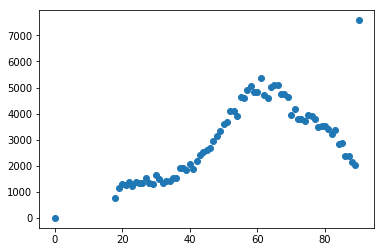

In [4]:
# Shows age distribution of the data set. There are 3 0-olds and 7579 90 year olds. 
# Implies that over nineties were grouped together
ages = trainDf['Age'].value_counts()
plt.scatter(ages.keys(),ages.values)

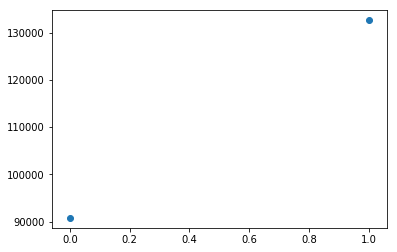

In [5]:
gender = trainDf['Male?'].value_counts()
plt.scatter(gender.keys(),gender.values)

0.0    201033
1.0     22380
Name: No Finding, dtype: int64


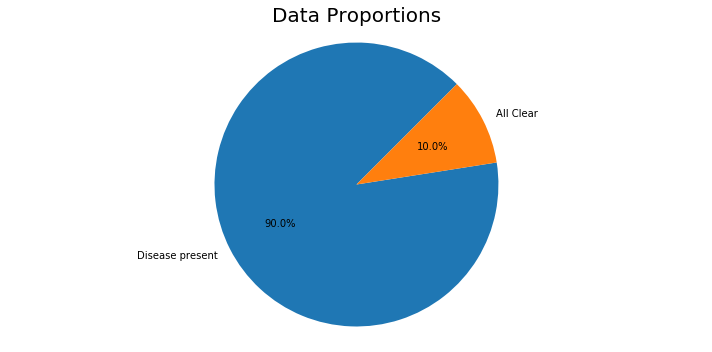

In [6]:
# How many people have no disease?
no_finding = trainDf['No Finding'].value_counts()
print(no_finding)

# Plot pie chart to show how much of the data is labelled with each character
values = no_finding.values
labels = ['Disease present','All Clear']

# Plot
plt.figure(figsize=(10, 5))
plt.title('Data Proportions', size=20)
plt.pie(values, labels=labels, # explode=explode,
        autopct='%1.1f%%', shadow=False, startangle=45)
 
plt.axis('equal')
plt.tight_layout()
plt.show()



In [7]:
trainDf

,Patient ID,Study,Path,Age,Male?,Frontal1/Lateral0,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,...,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,00001,1,CheXpert-v1.0-small/train/patient00001/study1/...,68,0,1,AP,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,00002,2,CheXpert-v1.0-small/train/patient00002/study2/...,87,0,1,AP,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,00002,1,CheXpert-v1.0-small/train/patient00002/study1/...,83,0,1,AP,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,00002,1,CheXpert-v1.0-small/train/patient00002/study1/...,83,0,0,0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,00003,1,CheXpert-v1.0-small/train/patient00003/study1/...,41,1,1,AP,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,00004,1,CheXpert-v1.0-small/train/patient00004/study1/...,20,0,1,PA,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,00004,1,CheXpert-v1.0-small/train/patient00004/study1/...,20,0,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,00005,1,CheXpert-v1.0-small/train/patient00005/study1/...,33,1,1,PA,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,00005,1,CheXpert-v1.0-small/train/patient00005/study1/...,33,1,0,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,00005,2,CheXpert-v1.0-small/train/patient00005/study2/...,33,1,1,AP,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [8]:

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    return files


def path_to_tensor(img_path,inputSize):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, color_mode = "grayscale", target_size=inputSize)
    # convert PIL.Image.Image type to 3D tensor with shape (x, x, 1)
    x = image.img_to_array(img)
    data = np.asarray( img, dtype="int32" )
    # convert 2D tensor to 3D tensor with shape (1, X, x) and return 3D tensor
    return data.reshape(1,inputSize[0],inputSize[1])

def paths_to_tensor(img_paths, inputSize):
    list_of_tensors = [path_to_tensor(img_path, inputSize) for img_path in img_paths]
    return np.array(list_of_tensors)


def path_to_tensor_channel_last_3colour(img_path,inputSize):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, color_mode = "grayscale", target_size=inputSize)
    # convert PIL.Image.Image type to 3D tensor with shape (x, x, 1)
    x = image.img_to_array(img)
    data = np.asarray( img, dtype="int32" )
    # convert 2D tensor to 3D tensor with shape (X, x, 3) and return 3D tensor
    return np.stack((data,)*3, axis=-1)


def paths_to_tensor_channel_last_3colour(img_paths, inputSize):
    list_of_tensors = [path_to_tensor_channel_last_3colour(img_path, inputSize) for img_path in img_paths]
    return np.array(list_of_tensors)

In [9]:
inputSize = (224,224)

sample_size =20000 # 30k is the memory limit for the server
targetColumn = [12]
colName = trainDf.columns.tolist()[targetColumn[0]]
print(f"This model will be targetting {colName} column")


# Create balanced dataset with 50% pos examples and 50% neg examples, only take scans from the front
pos = trainDf[(trainDf[colName] == 1) & (trainDf['Frontal1/Lateral0'] == 1 ) & (trainDf['AP/PA'] == 'AP')]
neg = trainDf[(trainDf['No Finding'] == 1) & (trainDf['Frontal1/Lateral0'] == 1 ) & (trainDf['AP/PA'] == 'AP')]




posSample = pos.sample(int(sample_size/2))
negSample = neg.sample(int(sample_size/2))
sample = pd.concat([posSample,negSample])

x_train_paths, x_val_paths, y_train, y_val = train_test_split(sample.Path, sample[colName], stratify=sample[colName], random_state =2)



# The 3 channel option is required for the denseNet and other transfer learning models
# Single channel can be used on our models

#x_train = paths_to_tensor(x_train_paths,inputSize)#.astype('float32')/255
x_train3Channel = paths_to_tensor_channel_last_3colour(x_train_paths,inputSize)#.astype('float32')/255

#y_train = trainDf.iloc[:training_no,targetColumn] # to do all labels: trainDf.iloc[:training_no,8:]
#x_val = paths_to_tensor(x_val_paths,inputSize)#.astype('float32')/255
x_val3Channel = paths_to_tensor_channel_last_3colour(x_val_paths,inputSize)#.astype('float32')/255

#y_val = trainDf.iloc[training_no:training_no+val_no,targetColumn]

# Deleting dataframes in order to save memory and avoid OOM errors. 
del trainDf
del posSample
del negSample
del x_train_paths
del x_val_paths


This model will be targetting Edema column


In [10]:
'''
print(len(y_val))
print(x_train[0].shape)
plt.imshow(x_train[0][0], interpolation='nearest')
plt.show()
'''

"\nprint(len(y_val))\nprint(x_train[0].shape)\nplt.imshow(x_train[0][0], interpolation='nearest')\nplt.show()\n"

In [11]:
# OLDMODEL

'''

model = Sequential()

model.add(Conv2D(64, (3,3), strides=(1,1), input_shape=(1,inputSize[0],inputSize[1])))
model.add(Conv2D(32, (3,3)))
model.add(Conv2D(16, (3,3)))

model.add(Flatten())
#model.add(Dropout(0.2))
#model.add(Dense(32,activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(16,activation='relu'))
#model.add(Dropout(0.2))



model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
weightsFilePath="weights.best.hdf5"
'''

'\n\nmodel = Sequential()\n\nmodel.add(Conv2D(64, (3,3), strides=(1,1), input_shape=(1,inputSize[0],inputSize[1])))\nmodel.add(Conv2D(32, (3,3)))\nmodel.add(Conv2D(16, (3,3)))\n\nmodel.add(Flatten())\n#model.add(Dropout(0.2))\n#model.add(Dense(32,activation=\'relu\'))\n#model.add(Dropout(0.2))\n#model.add(Dense(16,activation=\'relu\'))\n#model.add(Dropout(0.2))\n\n\n\nmodel.add(Dense(1, activation=\'sigmoid\'))\nmodel.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\nmodel.summary()\nweightsFilePath="weights.best.hdf5"\n'

In [12]:
# OLDMODEL
'''
checkpoint = ModelCheckpoint(weightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit(x_train,y_train, epochs = 10, batch_size=32,  validation_data=(x_val, y_val), callbacks=[checkpoint])
model.load_weights(weightsFilePath)
'''

"\ncheckpoint = ModelCheckpoint(weightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')\n\nhistory = model.fit(x_train,y_train, epochs = 10, batch_size=32,  validation_data=(x_val, y_val), callbacks=[checkpoint])\nmodel.load_weights(weightsFilePath)\n"

In [13]:
def checkAcc(predictions, truths):
    wrongs = 0
    for i,prediction in enumerate(predictions):
        truth = truths[i]
        for j, val in enumerate(prediction):
            if val >= 0.5 and truth[j] == 0:
                wrongs += 1
                # break
            if val < 0.5 and truth[j] == 1:
                wrongs += 1
                # break
    total = 41*len(predictions) # len(predictions)
    return (total - wrongs) / total, wrongs, total
                
            
#checkAcc(predictions, y_val.values)

In [14]:
y_val.values.shape

(5000,)

## Things to try:
- Could try using class weighting to handle class imbalance rather than sampling data to have no class imbalance
- Adding in the other data as an input to a fully connected layer. This would allow network to use gender and age in it's predictions.
- Try using no finding for the neg samples rather than 0 for the column, that way we don't have it confuse diseases. 


All of these were tested on the fracture data with 10k samples. 
## 1st Architecture:
Tried using densenet with untrainable layers straighinto 0.3 dropout and 1 unit sigmoid output layer
It acheived training acc around 70% and val acc of 56% after 10 epochs but didn't seem to be clearly improving

## 2nd architecture
 Tried an architecture with include_top = False and two layers of 128 units and 0.2 dropouts. 
however it never got past a training acc of around 0.5. This motivates me to increase the complexity of the model and train more of it. 
## 3rd Architecture
Same as first, but now trying with densenet first 200 layers as untrainable but rest trainable and removing last layer so it has only one class sigmoid rather than 1000 class softmax. This hadn't been possible on my laptop efore due to memm issues but is possible on Johnny's server. By removing the last layer we reduce the number of params by 1million, but allowing trainability means the network takes longer to train as we have ~4million trainable parameters. Achieved 95% training accuracy but only 54% val accuracy. At least this means we're able to get a decent accuracy somewhere, we clearly just need to prevent overfitting. Can't increase much more than 10k dataset, so best to try other ways to prevent overfitting -> dropout layers, or reducing trainable params

## 4th Architecture
addition of dropout layer before the last dense layer and also set the untrainable to be the first 300 layers rather than 200. reduces trainable params to 2 million. This actually resulted in training accuracy reaching 98% within 4 epochs, which is a bit disappointing/confusing. val acc maxed out at 0.50240Perhaps the trainble layers require more dropout or perhaps i need to furhter reduce the trainable params.Perhaps the difficulty is that it is seeing one of the other diseases, that can look like a fracture, so perhaps the data should be weighted to be 50% fracture, 50% no finding to avoid confusion -> however this is not how the model might be used in future so might not be a valid approach. perhaps it needs a higher weighting of the no-finding to achieve something similar but still training it to distinguish between fracture and other diseases. 

## 5th Architecture
To avoid the overfitting, we reduce the number of trainable layers, so the first 400 layers are untrainable. Results in a mere 575K parameters to train. Reached val accuracy of 57% and trainina accuracy of aroun 80%. 

## 6th Architecture
Changing the target column to be Enlarged Cardiomediastinum as that was found to be easier to detect in previous papers. Doing this also allowed us to increase the number of samples we use to 30K from 10K which should help a lot. Also increased untrainable layers to 420. This reduces trainable parameters to 200K.  If this doesn't work then we would also like to try data augementation I our next architecture to create more data, which will help the model generalise. Results were 80% training accuracy, 51% val accuracy. Therefore it's not working very well. 

## 7th Architecture
Adding data augmentation. This changes the images slightly to increase the number of samples. Changes include slight rotations, slight translations. The images were also constrained to only include the PA angle, this reduced the number of samples to 20000. The training accuracy was 70% and val accuracy maxed out at 51%.

## 8th
same as 7th but using no finding as the negative case to avoid confusion with other diseases. Seemed very unstable but achieve max val acc of 56% and training acc of 66%. 

## 9th
Tried freezing all the densenet layers. Reduced batch size to 16 to match the checxpert paper. 50k parameters. trainign 70% and val 50%.

## 10th
After reading: https://arxiv.org/pdf/1711.05225.pdf it turns out our original architecutre was much more similar to their papaer which ad some success. To more closely match theirs, i will change the disease to pneumonia, have all layers trainable and also set batch size to 16 to match their paper. They allow flipping of the image, which i think is invalid so will keep our data augmentation techniques. 7 million parameters. The batch size of 16 means we have a lot of backpropagations but it's much slower as a result. 
Achieved a training accuracy of 65% and validation accuracy of 72%, which is strange but we can see the val acc is very unstable so perhaps more reasonable to say around 70% if we take the average of the last few. 

## 11th
Same as 10th, but to deal with the instability I increaed the epochs to 100. I will then repeat this architecture for different diseases and see what we get. 

## 12th 
11th was going to take 5 hours and we weres till seeing instability after 35 epochs so reduced to 20 epochs to help us understnd the instability. We also tried to run with batchsie 64 to reduce instability we had seen but gpu mem was too small for this so kept it at 16. Note pneumonia scored 76% val acc and 65% training acc. 


In [15]:
# Trnsfer learning model
# put into separate cell as getting the dense net takes time 
# and we often only want to tweak the downstream architecutre 
denseNet = DenseNet121(input_shape=(224,224,3), include_top=True)
denseNet.layers.pop() # remov elast layer which has 1000 class softmax in it


In [16]:
model2Layers = Flatten()(denseNet.layers[-2].output)
model2Layers = Dropout(0.3)(model2Layers)
model2Layers = Dense(1,activation='sigmoid')(model2Layers)
model2 = Model(input=denseNet.layers[0].input, output=model2Layers)
for i,layer in enumerate(model2.layers):
    # Don't train the first layers to save mem and they wil be picking up low level features anyway. 
    if i < 428:
        #layer.trainable=False
        continue
    else:
        continue
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()
weightsFilePath2="weights2.best.hdf5"


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

/home/thebox/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


In [17]:
checkpoint2 = ModelCheckpoint(weightsFilePath2, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
image_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15)
#numberimage_gen.fit(x_train3Channel, augment=True)

batch_size = 16
epochs = 20
#history2 = model2.fit(x_train3Channel,y_train, epochs = 10, batch_size=128,  validation_data=(x_val3Channel, y_val), callbacks=[checkpoint2])
history2 = model2.fit_generator(image_gen.flow(x_train3Channel, y_train, batch_size=batch_size),steps_per_epoch=len(x_train3Channel) / batch_size,  epochs = epochs, validation_data=(x_val3Channel, y_val), callbacks=[checkpoint2])
model2.load_weights(weightsFilePath2)

Epoch 1/20
938/937 [==============================] - 260s 278ms/step - loss: 1.4743 - acc: 0.5924 - val_loss: 1.5310 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to weights2.best.hdf5
Epoch 2/20
938/937 [==============================] - 247s 264ms/step - loss: 1.4736 - acc: 0.6165 - val_loss: 7.9553 - val_acc: 0.4908

Epoch 00002: val_acc did not improve from 0.50000
Epoch 3/20
938/937 [==============================] - 246s 263ms/step - loss: 1.2724 - acc: 0.6376 - val_loss: 0.8709 - val_acc: 0.5622

Epoch 00003: val_acc improved from 0.50000 to 0.56220, saving model to weights2.best.hdf5
Epoch 4/20
938/937 [==============================] - 245s 262ms/step - loss: 1.1209 - acc: 0.6656 - val_loss: 4.1112 - val_acc: 0.5776

Epoch 00004: val_acc improved from 0.56220 to 0.57760, saving model to weights2.best.hdf5
Epoch 5/20
938/937 [==============================] - 245s 261ms/step - loss: 1.1694 - acc: 0.6643 - val_loss: 0.9315 - val_acc: 0.5878

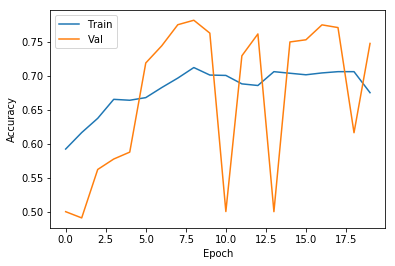

In [18]:
# Plot the history of this model
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
maxValAcc = max(history2.history['val_acc'])
trainAcc = history2.history['acc'][history2.history['val_acc'].index(maxValAcc)]
plt.savefig(f"Architecture10-{epochs}epochs-{colName}--trainAcc-{trainAcc}--valAcc-{maxValAcc}.png")
model2.save_weights(f"Architecture10-{epochs}epochs-{colName}--trainAcc-{trainAcc}--valAcc-{maxValAcc}.hdf5")
plt.show()

SyntaxError: invalid syntax (<ipython-input-19-e031fb49d38f>, line 1)